# THE  🔵   F · R · I · E · N · D · S  🔴  API 🟡

<img width=600 src="https://e00-telva.uecdn.es/assets/multimedia/imagenes/2020/04/22/15875459933127.jpg">

In [27]:
import pandas as pd
import os
import src.downloading_and_cleaning as dc
import src.data as d
import src.sia as sia
import src.frequency as f
from tqdm import tqdm
import json
from pymongo import MongoClient
import requests
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tqdm import tqdm
import matplotlib.pyplot as plt
import collections
import re

### 1. Downloading dataset from kaggle 💻

In [2]:
dc.download_dataset()

0

In [3]:
df = pd.read_csv("data/dataset.csv")

### 2. Preparing the data that will be imported to MongoDB ⚡️🚀

#### 2.1 Cleaning dataframe 🧹

In [4]:
main_characters = ['Joey', 'Chandler', 'Ross', 'Monica', 'Rachel', 'Phoebe', 'Gunther', 'Mike', 'Janice']

In [5]:
df = dc.cleaning(df,main_characters)

In [6]:
df.head()

,index,author,episode_number,episode_title,quote,season
0,0,Monica,1,Monica Gets A Roommate,There's nothing to tell! He's just some guy I ...,1
1,1,Joey,1,Monica Gets A Roommate,"C'mon, you're going out with the guy! There's ...",1
2,2,Chandler,1,Monica Gets A Roommate,"All right Joey, be nice. So does he have a hum...",1
3,3,Phoebe,1,Monica Gets A Roommate,"Wait, does he eat chalk?",1
4,4,Phoebe,1,Monica Gets A Roommate,"Just, 'cause, I don't want her to go through w...",1


#### 2.2 Adding a colum with the polarity of each quote 😁🥲

In [7]:
df["sia"] = df["quote"].apply(sia.sentimentAnalysis)

In [8]:
df["sentiment"] = df["sia"].apply(sia.grade_to_sent)

In [9]:
main_sentiment = list(sia.main_sent(df,main_characters).values())
main_sentiment

['neutral',
 'neutral',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'neutral',
 'neutral']

#### 2.3 Counting the most frequent words 🔢

In [10]:
stop_words = f.stopwds()

In [11]:
common_word = list((f.commonwds(main_characters,df,stop_words)).values())

In [12]:
common_word

['ross',
 'monica',
 'rachel',
 'chandler',
 'ross',
 'monica',
 'joey',
 'know',
 'know']

In [13]:
dict_ = { 'character' : main_characters,
         'word' : common_word,
         'sentiment' : main_sentiment
        }

new_df = pd.DataFrame.from_dict(dict_)
new_df

,character,word,sentiment
0,Joey,ross,neutral
1,Chandler,monica,neutral
2,Ross,rachel,positive
3,Monica,chandler,positive
4,Rachel,ross,positive
5,Phoebe,monica,positive
6,Gunther,joey,positive
7,Mike,know,neutral
8,Janice,know,neutral


In [14]:
new_df.to_json("friends_json",orient="records")

### 3. Creating a `friends` database with a `quotes` collection in MongoDB 

In [15]:
f = open("script", "w")
f.write("[{}]")
f.close()

In [16]:
url = "http://localhost:5000/newcharacter"

In [17]:
!mongoimport --db friends --collection quotes --jsonArray script

2021-05-02T19:53:30.158+0200	connected to: mongodb://localhost/
2021-05-02T19:53:30.164+0200	1 document(s) imported successfully. 0 document(s) failed to import.


### 4. Adding data to de collection

In [18]:
list_of_characters = ['Joey', 'Chandler', 'Ross', 'Monica', 'Rachel', 'Phoebe', 'Gunther', 'Mike', 'Janice']

In [19]:
with tqdm(total=len(list_of_characters)) as pbar:
    for character in list_of_characters:
        d.adding_character(df.to_dict(orient='records'),url)
        pbar.update(1)
pbar.close()

 11%|█         | 1/9 [04:19<34:39, 259.88s/it]

New content added to de DB!!


 22%|██▏       | 2/9 [08:43<30:33, 261.93s/it]

New content added to de DB!!


 33%|███▎      | 3/9 [13:01<26:02, 260.45s/it]

New content added to de DB!!


 44%|████▍     | 4/9 [17:26<21:49, 261.92s/it]

New content added to de DB!!


 56%|█████▌    | 5/9 [21:36<17:11, 257.77s/it]

New content added to de DB!!


 67%|██████▋   | 6/9 [25:53<12:52, 257.38s/it]

New content added to de DB!!


 78%|███████▊  | 7/9 [30:15<08:37, 258.85s/it]

New content added to de DB!!


 89%|████████▉ | 8/9 [34:40<04:20, 260.97s/it]

New content added to de DB!!


100%|██████████| 9/9 [39:06<00:00, 260.71s/it]

New content added to de DB!!


In [20]:
!mongoimport --db friends --collection quotes --jsonArray friends_json

2021-05-02T20:32:36.917+0200	connected to: mongodb://localhost/
2021-05-02T20:32:36.926+0200	9 document(s) imported successfully. 0 document(s) failed to import.


The data can also be added as follows (without endpoint):

In [24]:
#df.to_json("script_friends_json",orient="records")
#!mongoimport --db friends --collection quotes --jsonArray script_friends_json

### 5. Using API 👀

#### ¿How many quotes does Monica say?

In [22]:
url = "http://localhost:5000/times/"
person = "Monica"
times = requests.get(url + person)
times.content

b'Monica says 68015 quotes'

<img width=300 src="https://media.giphy.com/media/LaabpwEUXVUhq/giphy.gif">

#### ¿How many quotes does they all say?

In [28]:
quotes_t = f.times(main_characters)

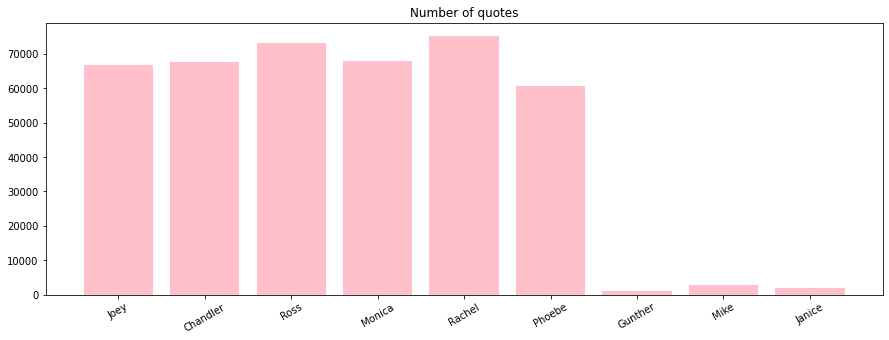

In [29]:
fig, ax = plt.subplots(figsize=(15, 5))
words_freq = plt.bar(*zip(*quotes_t.items()), color='pink')
ax.set_title("Number of quotes")
plt.xticks(rotation=30)
plt.show()

#### Give me a quote from Rachel

In [112]:
url = "http://localhost:5000/character/"
person = "Rachel"
quotes = requests.get(url + person).json()
quotes[18512]['quote'].replace("\x92","")

'I dont know, I dont know. Urrrgh! Look, maybe we should take a break.'

<img width=300 src="https://media.giphy.com/media/igsmXEkeyfPPgfU2yI/giphy.gif">

#### Give me a quote from the season 10

In [181]:
url = "http://localhost:5000/season/"
season = "10"
quotes = requests.get(url + season).json()
f"{quotes[8000]['author']} - {quotes[8000]['quote']}"

'Phoebe - Yes I did! Meet: Princess Consuela Banana Hammock! (She smiles from ear to ear)'

<img width=300 src="https://media.giphy.com/media/RkKqesulr2b5VPT67a/giphy.gif">

#### Give me a quote from the episode ` Ross's Tan `

In [185]:
url = "http://localhost:5000/episode/"
person = "Ross's Tan"
quotes = requests.get(url + person).json()
quotes[55]['quote']

"One Mississipi, two Mississipi, Three Mis...(the sprayer starts again, spraying him in the face and torso again) WAIT! WAIT! I'm not-I've not finished counting!! (he leaves the booth) (the assistant enters the room)"

<img width=300 src="https://media.giphy.com/media/12bO6mIZRgRHKU/giphy.gif">

#### Give me a quote from the `S10 E13 `

In [186]:
url_1 = "http://localhost:5000/season/"
url_2 = "/episode/"
season = "10"
episode = "13"
quotes = requests.get(url_1 + season + url_2 + episode).json()
quotes[54]['quote']

'Je de coup Clow.'

<img width=300 src="https://media.giphy.com/media/XdU9ThNglPBHLsOjDz/giphy.gif">

#### Give me a quote from Janice from the `S5 E12 `

In [34]:
url_1 = "http://localhost:5000/season/"
url_2 = "/episode/"
url_3 = "/character/"
season = "5"
episode = "12"
character = "Janice"
quotes = requests.get(url_1 + season + url_2 + episode + url_3 + character).json()
quotes[3]['quote']

'Oh! Okay! (To Ross) You, Mister Right Place at the Right Time, call me! (Does her famous, or is that infamous, laugh and exits.)'

<img width=300 src="https://media.giphy.com/media/hXOc9DJufLxpzo82zq/giphy.gif">

#### Give me a quote that contains `Pivot`

In [35]:
url = "http://localhost:5000/words/"
word = "Pivot"
quotes = requests.get(url + word).json()
quotes[0]['quote']

'Oh yeah it will! Come on, up! Up-up-up! Up! Yes! Here we go! Pivot! (They start up the stairs again. Chandler is between the couch and the wall now.) Pivot! Piv-ot! Piv-et!! Piv-ett!!! Piv-et!'

<img width=300 src="https://media.giphy.com/media/2OP9jbHFlFPW/giphy.gif">

#### How would you define Phoebe?

In [36]:
url = "http://localhost:5000/sentiment/"
character = "Phoebe"
sent = requests.get(url + character).json()
sent[0]['sentiment']

'positive'

<img width=300 src="https://media.giphy.com/media/LPs5pRt1OiaHqgTQoT/giphy.gif">

#### What is the word Chandler says most often?

In [40]:
url = "http://localhost:5000/word/"
character = "Chandler"
sent = requests.get(url + character).json()
sent[0]['word']

'monica'

<img width=300 src="https://media.giphy.com/media/H6hurOxfrUNWoChAVf/giphy.gif">

#### What are the most frequent words?

In [38]:
words = f.whole_script_common(df,main_characters,stop_words)

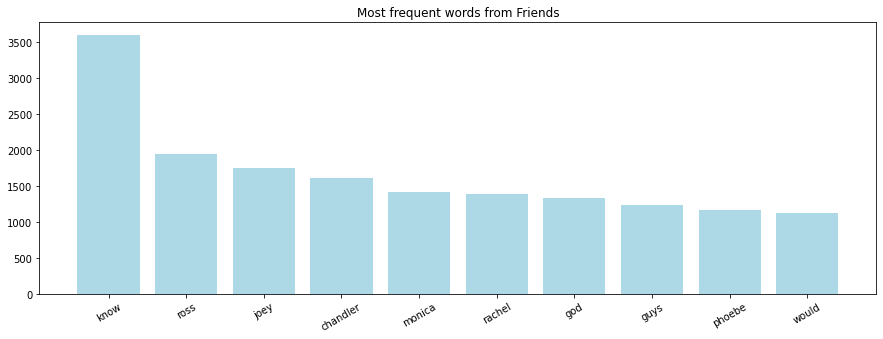

In [39]:
fig, ax = plt.subplots(figsize=(15, 5))
words_freq = plt.bar(*zip(*words.items()), color='lightblue')
ax.set_title("Most frequent words from Friends")
plt.xticks(rotation=30)
plt.show()